# Построение ML-продукта для выявления и оптимизации платежей преподавателей сервиса Repetit.ru

**Описание проекта**

Сервис передает контакты клиента (ученика) репетитору.  
Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия.  
Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают.  
Некоторые репетиторы плохо договариваются о занятиях или обманывают.  
Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору.  
Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник,  
чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.

Сейчас эта задача решается ручным просмотром сотрудниками или никак.

**Задачи:**
- Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий
  <br>будет классифицировать репетиторов на платящих и неэффективных.
- Оценка качества модели будет производиться с использованием метрики F1.


**Признаки обмана, выявленные при ручной проверке**

Заказчик произвел ручную проверку репетиторов на предмет мошенничества (звонки клиентам и так далее).  
Выяснилось, что 20% обманывают нас так или иначе.
- Несоответствие цены в заявке, в анкете репетитора и реальной
- 1 занятие на ученика (соотношение к общему кол-ву занятий)
- Разная стоимость с разными учениками
- Разная стоимость уроков с одним учеником
- Стоят занятия в расписании, а оплат нет
- Когда у репетитора по разным ученикам оплаты рядом по времени, то он сам оплачивает
- Как часто заходит в приложение - если редко, то сам оплачивает
- Статус заявки договорились о занятиях, оплат нет более недели (и не перенесено)
  - status в orders = 9
  - lessons с amount_payed > 0 за последнюю неделю
- Ученик не отмечен как завершенный, а оплат нет
  - В качестве примера, есть SQL запрос позволяющий получить данную информацию
- Репетитор отчитался, что провёл платное занятие, оплаты нет
  - В качестве примера, есть SQL запрос позволяющий получить данную информацию
- Цена ниже 500 р. в регионах, ниже 700 в мск


**Описание данных**

Информация о репетиторах (teacher_info.feather)

`id` - айди репетитора  
`reg_date` - дата регистрации  
`birth_date` - дата рождения  
`teaching_start_date` - дата начала первого занятия  
`is_email_confirmed` - подтвержден ли e-mail адресс  
`lesson_duration` - продолжит урока  
`lesson_cost` - стоимость урока  
`is_display` - показывается в каталоге  
`last_visited` - послеждний визит  
`is_pupils_needed` - открыт для заявок  
`is_cell_phone_confirmed` - подтвержден ли номер телефона  
`area_id` - регион  
`sex` - пол  
`orders_allowed` - разрешено назначать на заявки  
`review_num` - отзывы  


Статистика по репетиторам и таргет (teachers.feather)

`id` - айди репетитора  
`lessons_delivered` - поставлено уроков  
`mean_lesson_price` - средняя стоимость уроков  
`lessons_given` - оплачено уроков  
`lessons_started_fraction` - процент начала занятий  
`lessons_per_pupil` - занятий на ученика  
`money_recieved` - получено денег  
`blocked` - целевой признак (active/blocked)  

Ученики (lesson_course.feather)

`Id` - айди  
`client_id` - айди ученика  
`teacher_id` - айди репетитора  
`order_id` - айди заявки  
`lesson_place` - занятия онлайн или офлайн  
`lesson_price` - цена  
`is_active` - идут ли занятия, на паузе, завершены  
`lesson_duration` - продолжительность урока  
`date_updated`  
`suspend_till_date`  

Занятия (lessons.feather)

`Id` - айди  
`lesson_course_id` - айди ученика  
`lesson_date` - дата  
`time_from` - время от  
`time_to` - время до  
`home_task` - дз  
`is_regular` - автоматически повторяющееся занятие  
`amount_to_pay` - стоимость  
`amount_paid` - оплачено  

Цены на занятия репетиторов (teacher_prices.feather)

`date_update` - дата обновления цен  
`teacher_id` - айди репетитора  
`subject_id` - айди предмета  
`price` - цена занятий у себя  
`price_external` - цена занятий на выезде  
`price_remote` - цена онлайн занятий  

Заявки (orders.feather)

`order_date` - дата создания  
`subject_id` - предмет  
`purpose` - цель занятий  
`lesson_price` - цена  
`lesson_duration` - желаемая проодолжительность урока  
`home_metro_id` - ближайшее метро  
`add_info` - доп инфо  
`start_date`  
`working_teacher_id`  
`status_id` - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)  
`comments`  
`amount_to_pay`
`planned_lesson_number` - клиент планирует N занятий  
`first_lesson_date` - дата 1 занятия  
`creator_id` - кто создал заявку (id сотрудника или клиента)  
`pupil_category_new_id` - возраст ученика  
`lessons_per_week` - занятий а неделю  
`minimal_price`  
`teacher_sex` - пол репетитора  
`teacher_experience_from` - опыт репетитора от  
`teacher_experience_to` - опыт репетитора до  
`lesson_place_new` - онлайн, у ученика, у учителя  
`pupil_knowledgelvl` -уровень знаний ученика  
`teacher_age_from` - желаемый возраст репеитора от  
`teacher_age_to` - желаемый возраст репеитора от  
`chosen_teachers_only` - не предлагать репетиторов кроме выбранных самостоятельно  
`no_teachers_available` - на заявку нет подходящих репов  
`source_id` - где создана заявка (какая часть сайта, не регион)  
`original_order_id` - дублем какой заявки является эта заявка  
`client_id` - айди клиента  
`additional_status_id`  
`max_metro_distance` - максимально готов ехать от метро  
`estimated_fee`  
`payment_date`  
`test_group` - аб тесты  
`is_display_to_teachers` - хочет ли клиент получать отклики репетиторов

**Ход исследования**

- загрузка данных и ознакомление с ними,
- EDA,
- создание новых признаков,
- отбор финального набора обучающих признаков,
- подготовка данных для обучения,
- выбор и обучение моделей,
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- отчёт по проведённому исследованию.

## Настройка рабочей среды

In [6]:
# !pip install pandas
# !pip install pyarrow
# !pip install seaborn
# !pip install scikit-learn
# !pip install python-dotenv
# !pip install psycopg2-binary
# !pip install sqlalchemy

# !pip install phik
# !pip install catboost

In [1]:
import os
# import sys
import pandas as pd
import seaborn as sns
import psycopg2 as psycopg
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# библиотека для отбора важности признаков
# from sklearn.inspection import permutation_importance

# не нужные библиотеки
# from sqlalchemy import create_engine, MetaData

Установка констант

In [2]:
load_dotenv()
postgres_credentials = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD"),
}
teacher_prices_path = 'data/teacher_prices.feather'
teachers_info_path = 'data/teachers_info.feather'
lesson_course_path = 'data/lesson_course.feather'
teachers_path = 'data/teachers.feather'
lessons_path = 'data/lessons.feather'
orders_path = 'data/orders.feather'
RANDOM_STATE = 42

Импорт исследовательского класса

In [3]:
try:
    from research_class import DatasetExplorer
except:
    from google.colab import userdata
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(userdata.get('my_module'))
    import research_class
    research_class.DatasetExplorer

## Загрузка данных

In [7]:
try:
    # teacher_prices = pd.read_feather(teacher_prices_path)
    # teachers_info = pd.read_feather(teachers_info_path)
    # lesson_course = pd.read_feather(lesson_course_path)
    # teachers = pd.read_feather(teachers_path)
    # lessons = pd.read_feather(lessons_path)
    orders = pd.read_feather(orders_path)
    print('загружено из директории "data"')
except:
    teacher_prices = pd.read_feather(userdata.get('teacher_prices'))
    teachers_info = pd.read_feather(userdata.get('teachers_info'))
    lesson_course = pd.read_feather(userdata.get('lesson_course'))
    teachers = pd.read_feather(userdata.get('teachers'))
    lessons = pd.read_feather(userdata.get('lessons'))
    orders = pd.read_feather(userdata.get('orders'))
    print('загружено из директории Google Drive')

загружено из директории "data"


Проверка таблиц в базе данных

In [5]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
        print(f"существующие в базе таблицы: {cur.fetchall()}")

существующие в базе таблицы: [('teacher_prices',), ('teachers_info',), ('lessons',), ('teachers',), ('lesson_course',), ('orders',)]


### teacher_prices

In [18]:
TABLE_NAME = 'teacher_prices'
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

teacher_prices = pd.DataFrame(data, columns=columns).drop('index', axis=1)
print(f"таблица {TABLE_NAME} загружена, её размерность: {teacher_prices.shape}")

таблица teacher_prices загружена, её размерность: (432422, 6)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


,date_update,teacher_id,subject_id,price,price_external,price_remote
97742,2014-04-19 18:16:31.873,65221.0,11,700,700,0
366998,2022-05-31 20:17:56.590,261894.0,15,800,0,800
108605,2014-09-18 14:41:30.173,72291.0,11,0,0,3000
11308,2009-10-13 23:08:17.430,8031.0,1,1000,1000,700
353031,2021-12-12 18:57:26.973,250198.0,10,500,600,500


количество полных дубликатов строк: 860


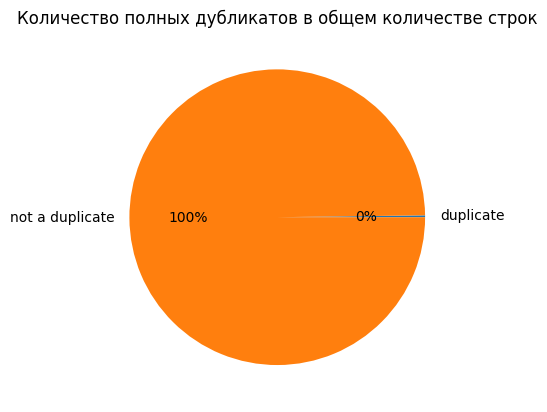

количество пропущенных значений:
date_update          0
teacher_id        4570
subject_id           0
price                0
price_external       0
price_remote         0
dtype: int64


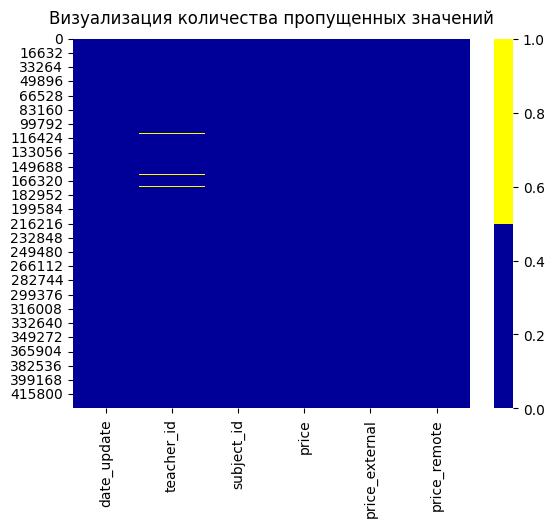

Процент пропущенных значений в признаках:
teacher_id: 1.06%
Количество уникальных значений в столбце 'teacher_id': 271396
Соотношение уникальных значений и общего количества записей в столбце 'teacher_id': 1.59

Количество уникальных значений в столбце 'subject_id': 27
Соотношение уникальных значений и общего количества записей в столбце 'subject_id': 16015.63



In [19]:
explorer_teacher_prices = DatasetExplorer(teacher_prices)
explorer_teacher_prices.explore_dataset()  # 432422

Точечное изучение нескольких пропущенных значений

In [20]:
# Получаем индексы пропущенных записей
missing_indices = teacher_prices[teacher_prices['teacher_id'].isna()].index

# Цикл для вывода окружения пропущенных индексов
for index in missing_indices[9:13]:
    print(f'Окружение пропущенной записи с индексом {index}:')
    display(teacher_prices.loc[index-2:index+2])

Окружение пропущенной записи с индексом 1950:


,date_update,teacher_id,subject_id,price,price_external,price_remote
1948,2008-09-21 16:08:45.620,1860.0,23,1000,1000,1000
1949,2008-09-21 16:12:48.057,1856.0,1,3500,4000,0
1950,2008-09-21 16:12:48.057,NaN,15,3000,4000,0
1951,2008-09-21 16:25:30.480,1861.0,8,0,0,2000
1952,2008-09-22 01:32:14.470,1374.0,6,750,750,750


Окружение пропущенной записи с индексом 2020:


,date_update,teacher_id,subject_id,price,price_external,price_remote
2018,2008-09-24 17:29:59.240,602.0,6,500,500,500
2019,2008-09-24 17:31:57.660,615.0,33,2500,2500,2500
2020,2008-09-24 17:31:57.660,NaN,33,2500,2500,2500
2021,2008-09-24 17:31:57.660,615.0,23,2500,2500,2500
2022,2008-09-24 17:32:42.097,979.0,2,1500,1500,0


Окружение пропущенной записи с индексом 2493:


,date_update,teacher_id,subject_id,price,price_external,price_remote
2491,2008-10-13 22:55:25.307,1761.0,2,700,0,0
2492,2008-10-13 22:55:46.883,354.0,2,0,450,0
2493,2008-10-13 22:55:46.883,NaN,1,0,450,0
2494,2008-10-13 23:02:10.443,2181.0,8,500,500,500
2495,2008-10-13 23:09:32.113,2147.0,2,1000,1000,1000


Окружение пропущенной записи с индексом 2736:


,date_update,teacher_id,subject_id,price,price_external,price_remote
2734,2008-10-23 22:48:04.080,2360.0,6,500,500,500
2735,2008-10-23 22:48:04.080,2360.0,2,500,500,500
2736,2008-10-23 22:56:19.877,NaN,2,1000,1000,1000
2737,2008-10-23 22:56:19.877,NaN,33,1000,1000,1000
2738,2008-10-23 22:59:47.717,2374.0,2,1500,1500,0


#### Выводы и заключения
- в признаке `date_update` необходимо изменить тип данных для корректного проведения дальнейших исследований;
- в признаке `teacher_id` также можно изменить тип данных для уменьшения объёма занимаемой памяти;
- обнаружены пропуски в `teacher_id`:
  - если пропущенные значения относятся к учителям выше или ниже по списку, то их можно заполнить;
  - ориентиром послужит точное совпадение в признаке `date_update`;
  - оставшиеся незаполненными записи будут исключены, т.к. объём датафрейма это позволяет;
- количество полных дубликатов записей составляет менее 1% от всего набора данных,  
  принимаю решение об их удалении;
- количество уникальных `teacher_id` в датафрейме - 271396, что примерно в полтора раза меньше общего количества записей,  
  это говорит о том, что некоторые преподаватели проводят обучение по нескольким предметам.

### teachers_info

In [24]:
TABLE_NAME = 'teachers_info'
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

teachers_info = pd.DataFrame(data, columns=columns).drop('index', axis=1)
print(f"таблица {TABLE_NAME} загружена, её размерность: {teachers_info.shape}")

таблица teachers_info загружена, её размерность: (307972, 15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
78044,80443,2015-01-15 12:52:27.000,1984-04-27 00:00:00.000,2010-09-01 00:00:00.000,0,40,1000,0,None,NaN,0,1,2,1,0
17340,17944,2010-10-04 12:20:43.000,1987-01-31 00:00:00.000,2005-09-01 00:00:00.000,0,60,700,1,2022-10-23 17:09:44.483,NaN,0,1,1,1,27
182540,186945,2019-11-24 12:16:59.837,2001-06-12 00:00:00.000,2019-09-01 00:00:00.000,0,60,0,0,2019-11-24 12:17:00.570,NaN,0,2,1,1,0
115339,118729,2017-04-16 14:03:05.000,1990-06-05 00:00:00.000,2011-09-01 00:00:00.000,0,60,1200,1,2022-10-04 21:22:46.107,NaN,0,1,2,1,1
73076,75202,2014-10-16 11:14:37.000,1990-08-01 00:00:00.000,2009-09-01 00:00:00.000,0,60,0,0,None,NaN,0,1,2,1,0


количество полных дубликатов строк: 0
количество пропущенных значений:
id                              0
reg_date                        0
birth_date                      0
teaching_start_date             0
is_email_confirmed              0
lesson_duration                 0
lesson_cost                     0
is_display                      0
last_visited                72135
is_pupils_needed           296764
is_cell_phone_confirmed         0
area_id                         0
sex                             0
orders_allowed                  0
review_num                      0
dtype: int64


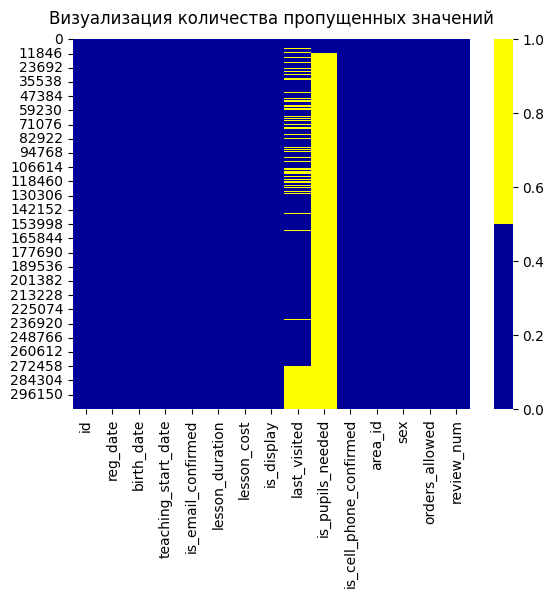

Процент пропущенных значений в признаках:
last_visited: 23.42%
is_pupils_needed: 96.36%
Количество уникальных значений в столбце 'id': 307972
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Количество уникальных значений в столбце 'area_id': 91
Соотношение уникальных значений и общего количества записей в столбце 'area_id': 3384.31



In [25]:
explorer_teachers_info = DatasetExplorer(teachers_info)
explorer_teachers_info.explore_dataset()  # 307972

#### Выводы и заключения
- для дальнейших исследований у данных признаков:
  <br>`reg_date`, `birth_date`, `teaching_start_date`, `last_visited` -
  <br>необходимо изменить тип данных на `datetime`;
- дубликатов строк в данных не обнаружено;
- в признаке `last_visited` почти четверть значений пропущена;
- в признаке `is_pupils_needed` пропущены почти все значения,
  <br>данный признак можно исключить из дальнейшего исследования;
- все `id` учителей в датафрейме уникальны
- признак `orders_allowed` необходимо исключить из дальнейших исследований,
  <br>т.к. он даёт утечку целевого признака.

### lesson_course

In [28]:
TABLE_NAME = 'lesson_course'
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

lesson_course = pd.DataFrame(data, columns=columns).drop('index', axis=1)
print(f"таблица {TABLE_NAME} загружена, её размерность: {lesson_course.shape}")

таблица lesson_course загружена, её размерность: (893438, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
399095,1057355,1000942.0,33465,2226016.0,2,500,1,60,2022-09-29 19:25:33.997,1800-01-01 00:00:00.000
531828,1237333,1122215.0,214868,2546912.0,4,1500,0,60,2023-04-05 15:29:32.610,1800-01-01 00:00:00.000
377536,1054893,997433.0,119157,2221309.0,4,2000,0,60,2022-09-27 15:47:54.470,1800-01-01 00:00:00.000
360939,917643,908419.0,58345,1969942.0,4,2000,1,60,2022-06-29 16:39:38.267,2022-09-12 00:00:00.000
184799,958001,936136.0,18197,2045284.0,6,1000,0,60,2022-04-27 16:44:19.140,1800-01-01 00:00:00.000


количество полных дубликатов строк: 0
количество пропущенных значений:
id                      0
client_id               1
teacher_id              0
order_id             3306
lesson_place            0
lesson_price            0
is_active               0
lesson_duration         0
date_updated            0
suspend_till_date       0
dtype: int64


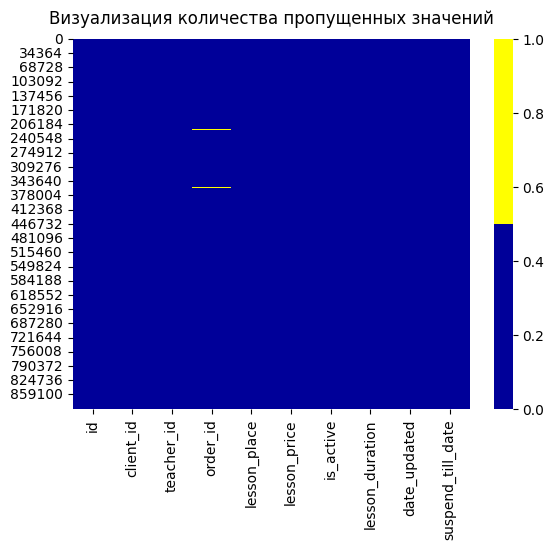

Процент пропущенных значений в признаках:
client_id: 0.00%
order_id: 0.37%
Количество уникальных значений в столбце 'id': 893438
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Количество уникальных значений в столбце 'client_id': 408319
Соотношение уникальных значений и общего количества записей в столбце 'client_id': 2.19

Количество уникальных значений в столбце 'teacher_id': 68187
Соотношение уникальных значений и общего количества записей в столбце 'teacher_id': 13.10

Количество уникальных значений в столбце 'order_id': 890129
Соотношение уникальных значений и общего количества записей в столбце 'order_id': 1.00



In [29]:
explorer_lesson_course = DatasetExplorer(lesson_course)
explorer_lesson_course.explore_dataset()  # 893438

#### Выводы и заключения
- пропуски в `client_id` и `order_id`, вероятно,
  <br>появились по причине ошибки и записи с ними необходимо исключить;
- дубликатов строк в датафрейме не обнаружено;
- у признаков `date_updated` и `suspend_till_date` нужно изменить тип данных на `datetime`

### teachers

In [32]:
TABLE_NAME = 'teachers'
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

teachers = pd.DataFrame(data, columns=columns).drop('index', axis=1)
print(f"таблица {TABLE_NAME} загружена, её размерность: {teachers.shape}")

таблица teachers загружена, её размерность: (1656, 8)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
316,192131,401.0,757.541899,179.0,0.115789,16.272727,135600.0,0
411,189372,1471.0,1402.412281,1140.0,0.247788,13.571429,1598750.0,0
443,77277,15.0,1500.000000,13.0,0.034483,13.000000,19500.0,0
1197,38188,48.0,969.696970,33.0,0.077519,3.300000,32000.0,1
1053,279654,56.0,2300.000000,10.0,0.033898,5.000000,23000.0,0


количество полных дубликатов строк: 0
количество пропущенных значений:
id                          0
lessons_delivered           0
mean_lesson_price           0
lessons_given               0
lessons_started_fraction    0
lessons_per_pupil           0
money_recieved              0
blocked                     0
dtype: int64
Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'id': 1656
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Соотношение классов целевой переменной:
			blocked
1     557
0    1099
Name: count, dtype: int64


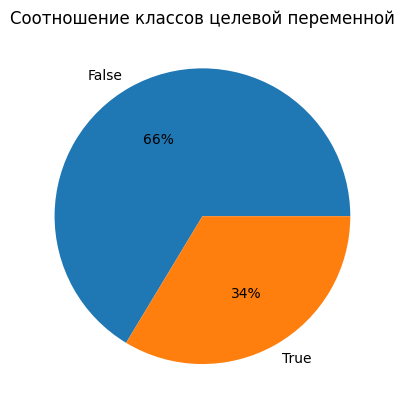

In [33]:
explorer_teachers = DatasetExplorer(teachers, target='blocked')
explorer_teachers.explore_dataset()

#### Выводы и заключения
- в датафрейме пропусков не обнаружено;
- дубликатов строк не обнаружено;
- все представленные `id` учителей уникальны;
- наблюдается дисбаланс классов целевой переменной.

### lessons

In [5]:
TABLE_NAME = 'lessons'
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

lessons = pd.DataFrame(data, columns=columns).drop('index', axis=1)
print(f"таблица {TABLE_NAME} загружена, её размерность: {lessons.shape}")

таблица lessons загружена, её размерность: (1191127, 9)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1191127 non-null  int64  
 1   lesson_course_id  1191127 non-null  int64  
 2   lesson_date       1191127 non-null  object 
 3   time_from         1191127 non-null  object 
 4   time_to           1191127 non-null  object 
 5   home_task         4969 non-null     object 
 6   is_regular        1191127 non-null  int64  
 7   amount_to_pay     593376 non-null   float64
 8   amount_paid       8143 non-null     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 81.8+ MB


,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
146087,1939880,402693,2021-11-11 00:00:00.000,15:00:00,16:00:00,None,0,800.0,NaN
324649,2297148,906838,2022-04-09 00:00:00.000,11:00:00,12:00:00,None,0,NaN,NaN
544408,2787710,581824,2023-07-29 00:00:00.000,09:00:00,10:00:00,None,0,450.0,NaN
205521,2050219,864168,2021-12-07 00:00:00.000,18:30:00,19:30:00,None,0,300.0,NaN
819580,3361398,1180405,2023-09-19 00:00:00.000,14:00:00,15:00:00,None,0,NaN,NaN


количество полных дубликатов строк: 0
количество пропущенных значений:
id                        0
lesson_course_id          0
lesson_date               0
time_from                 0
time_to                   0
home_task           1186158
is_regular                0
amount_to_pay        597751
amount_paid         1182984
dtype: int64


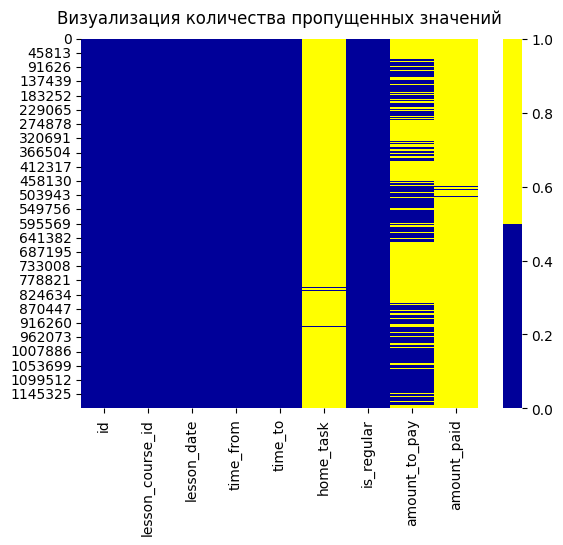

Процент пропущенных значений в признаках:
home_task: 99.58%
amount_to_pay: 50.18%
amount_paid: 99.32%
Количество уникальных значений в столбце 'id': 1191127
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Количество уникальных значений в столбце 'lesson_course_id': 203876
Соотношение уникальных значений и общего количества записей в столбце 'lesson_course_id': 5.84

Количество уникальных значений в столбце 'amount_paid': 61
Соотношение уникальных значений и общего количества записей в столбце 'amount_paid': 19526.67



In [6]:
explorer_lessons = DatasetExplorer(lessons)
explorer_lessons.explore_dataset()

#### Выводы и заключения
- дубликатов строк не обнаружено;
- в признаках `home_task` и `amount_paid` более 99% пропусков -
  <br>данные признаки будут исключены;
- все представленные `id` уроков уникальны.

### orders

In [ ]:
TABLE_NAME = 'orders'
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")# LIMIT 10")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

orders = pd.DataFrame(data, columns=columns)
print(f"таблица {TABLE_NAME} загружена, её размерность: {orders.shape}")

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
98116,1841564,2021-10-31 23:54:59.823,4.0,Разделы: общий курс.\nДополнения: DALF.\nКатег...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2021-11-01 13:43:11.323,...,0,0,16,NaN,865111,21.0,NaN,2160,2021-11-24 23:04:22.840,1
33971,1875538,2021-11-30 18:58:53.437,17.0,"Разделы: финансовый менеджмент, финансы.\nКате...",1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,None,...,1,0,2,NaN,876098,18.0,NaN,None,None,1
306105,2894117,2023-10-17 21:54:30.997,27.0,Разделы: общая подготовка.\nКатегория ученика:...,1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2023-10-18 13:10:57.637,...,0,0,23,NaN,1253154,10.0,NaN,2950,None,0
279235,2867247,2023-10-08 09:21:03.810,11.0,"Дополнения: ЕГЭ, ОГЭ (ГИА).\nКатегория ученика...",2500,60,None,189.0,Район: м. Митино.\nМесто проведения занятий: у...,2023-10-08 12:31:02.527,...,0,0,23,NaN,1243345,13.0,NaN,8125,None,0
105287,2583906,2023-04-26 10:43:27.683,2.0,Дополнения: ОГЭ (ГИА).\nКатегория ученика: шко...,1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2023-04-26 10:45:04.347,...,0,0,14,2580376.0,966963,13.0,NaN,1500,None,1


количество полных дубликатов строк: 900


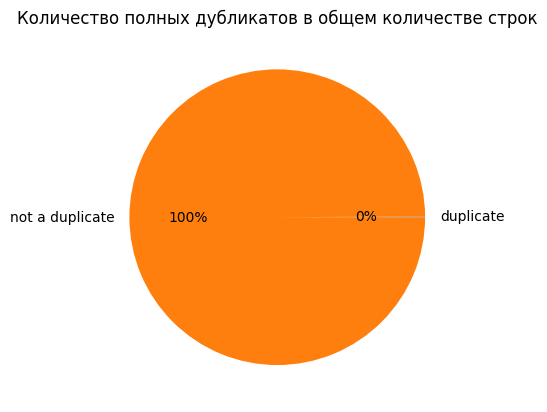

количество пропущенных значений:
id                               0
order_date                       0
subject_id                   10332
purpose                     166510
lesson_price                     0
lesson_duration                  0
lesson_place               1191830
home_metro_id               549414
add_info                    147173
start_date                  486283
working_teacher_id          485873
status_id                        0
comments                    850393
prefered_teacher_id        1191857
amount_to_pay                    0
planned_lesson_number            0
first_lesson_date          1025290
creator_id                  612163
pupil_category_new_id       159391
lessons_per_week                 0
minimal_price                    0
teacher_sex                      0
teacher_experience_from          0
teacher_experience_to            0
lesson_place_new                 0
pupil_knowledgelvl               0
teacher_age_from                 0
teacher_age_to        

In [8]:
explorer_orders = DatasetExplorer(orders)
explorer_orders.explore_dataset() # 1191861

#### Выводы и заключения
- количество полных дубликатов строк менее 1% - их можно удалить;
- в признаках `lesson_place`, `comments`, `prefered_teacher_id`,
  <br>`first_lesson_date`, `max_metro_distance`, `payment_date`
  <br>больше половины пропусков - эти признаки можно удалить.

## Предобработка данных

### teacher_prices

Заполнение пропущенных значений

In [21]:
for index, row in teacher_prices.iterrows():
    if pd.isnull(row['teacher_id']):
        # Генерируем "обрезанный" date_update для сравнения
        trimmed_date_update = row['date_update'][:-4]

        # Проверяем наличие совпадения признака date_update (обрезанного) выше и ниже
        prev_row = teacher_prices.iloc[index - 1] if index - 1 >= 0 else None
        next_row = teacher_prices.iloc[index + 1] if index + 1 < len(teacher_prices) else None

        if prev_row is not None and prev_row['date_update'][:-4] == trimmed_date_update:
            teacher_prices.at[index, 'teacher_id'] = prev_row['teacher_id']
        elif next_row is not None and next_row['date_update'][:-4] == trimmed_date_update:
            teacher_prices.at[index, 'teacher_id'] = next_row['teacher_id']

teacher_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      429104 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      429104 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


,date_update,teacher_id,subject_id,price,price_external,price_remote
205860,2018-01-10 16:09:30.653,136487.0,29,0,2000,1800
312084,2020-10-30 15:23:43.407,216935.0,2,0,500,400
55325,2012-03-28 12:28:09.153,38066.0,2,1000,1000,1000
401412,2023-03-31 01:43:04.790,290030.0,11,0,0,750
361784,2022-03-23 18:21:15.090,257632.0,18,750,850,750


количество полных дубликатов строк: 864


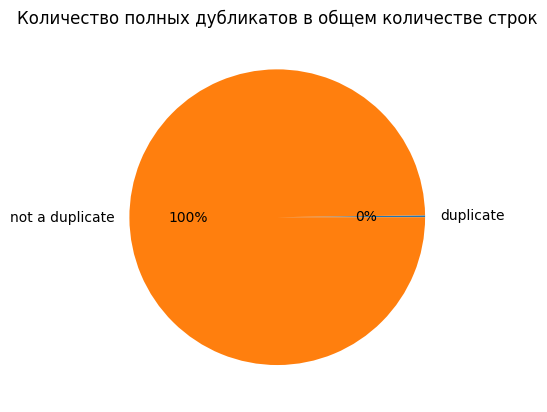

количество пропущенных значений:
date_update          0
teacher_id        3318
subject_id           0
price                0
price_external       0
price_remote         0
dtype: int64


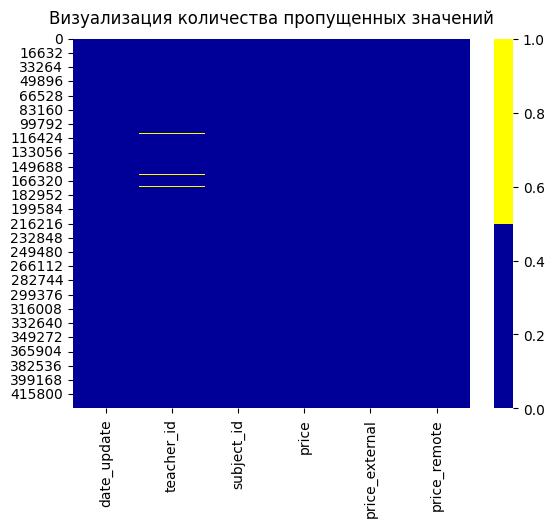

Процент пропущенных значений в признаках:
teacher_id: 0.77%
Количество уникальных значений в столбце 'teacher_id': 271396
Соотношение уникальных значений и общего количества записей в столбце 'teacher_id': 1.59

Количество уникальных значений в столбце 'subject_id': 27
Соотношение уникальных значений и общего количества записей в столбце 'subject_id': 16015.63



In [22]:
explorer_teacher_prices.explore_dataset()

Выполнение предобработки датафрейма

In [23]:
teacher_prices = explorer_teacher_prices.data_preprocessing(
    date_features = 'date_update',
    int_features = 'teacher_id'
)

<class 'pandas.core.frame.DataFrame'>
Index: 428243 entries, 0 to 431557
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date_update     428243 non-null  datetime64[ns]
 1   teacher_id      428243 non-null  int64         
 2   subject_id      428243 non-null  int64         
 3   price           428243 non-null  int64         
 4   price_external  428243 non-null  int64         
 5   price_remote    428243 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 22.9 MB


,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125,13,0,0,3000
2,2008-01-22 00:33:39.660,125,14,0,0,3000
3,2008-01-22 00:37:01.963,91,8,2000,0,0
4,2008-02-08 21:27:19.177,372,33,400,400,400


#### Выводы и заключения
- заполнены некоторые пропущенные значения `teacher_id` по совпадению признака `date_update`;
- количество дубликатов практически не изменилось после заполнения пропусков;
- дубликаты удалены;
- количество оставшихся пропусков около 1%;
- пропуски удалены

### teachers_info

In [26]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

In [27]:
teachers_info = explorer_teachers_info.data_preprocessing(
    dropnas=False,
    date_features = ['reg_date', 'birth_date', 'teaching_start_date', 'last_visited'],
    int_features=None,
    drop_features = ['is_pupils_needed', 'orders_allowed']
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       307972 non-null  int64         
 1   reg_date                 307972 non-null  datetime64[ns]
 2   birth_date               307972 non-null  datetime64[ns]
 3   teaching_start_date      307972 non-null  datetime64[ns]
 4   is_email_confirmed       307972 non-null  int64         
 5   lesson_duration          307972 non-null  int64         
 6   lesson_cost              307972 non-null  int64         
 7   is_display               307972 non-null  int64         
 8   last_visited             235837 non-null  datetime64[ns]
 9   is_cell_phone_confirmed  307972 non-null  int64         
 10  area_id                  307972 non-null  int64         
 11  sex                      307972 non-null  int64         
 12  review_num      

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_cell_phone_confirmed,area_id,sex,review_num
0,33,2007-12-24 19:26:46,1983-06-05,1989-09-01,0,60,1000,1,2022-10-24 16:48:38.410,0,1,1,6
1,46,2007-12-24 19:26:46,1980-02-12,2003-09-01,0,60,500,0,NaT,0,1,3,0
2,51,2007-12-24 19:26:46,1965-04-30,1988-09-01,0,60,1500,0,2022-09-26 09:43:56.123,0,1,2,0
3,52,2007-12-24 19:26:46,1988-07-06,2006-09-01,0,60,1000,1,2020-04-03 15:53:50.867,0,1,2,2
4,54,2007-12-24 19:26:46,1985-09-30,2004-01-01,0,45,400,0,NaT,0,1,3,0


#### Выводы и заключения
- у признаков изменены типы данных по необходимости;
- удалены неинформативные и дающие утечку признаки;
- удалены дубликаты

### lesson_course

In [30]:
lesson_course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


In [31]:
lesson_course = explorer_lesson_course.data_preprocessing(
    dropnas=True,
    date_features = ['date_updated', 'suspend_till_date'],
    int_features = ['client_id', 'order_id'],
    drop_features=None
)

<class 'pandas.core.frame.DataFrame'>
Index: 890131 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 890131 non-null  int64         
 1   client_id          890131 non-null  int64         
 2   teacher_id         890131 non-null  int64         
 3   order_id           890131 non-null  int64         
 4   lesson_place       890131 non-null  int64         
 5   lesson_price       890131 non-null  int64         
 6   is_active          890131 non-null  int64         
 7   lesson_duration    890131 non-null  int64         
 8   date_updated       890131 non-null  datetime64[ns]
 9   suspend_till_date  890131 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(8)
memory usage: 74.7 MB


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831,133738,718009,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075,106838,720876,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089,14700,720912,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940,138783,721219,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704,3476,720891,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000


#### Выводы и заключения
- удалены дубликаты;
- удалены пропущенные значения;
- изменены типы данных по необходимости

### lessons

In [7]:
lessons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1191127 non-null  int64  
 1   lesson_course_id  1191127 non-null  int64  
 2   lesson_date       1191127 non-null  object 
 3   time_from         1191127 non-null  object 
 4   time_to           1191127 non-null  object 
 5   home_task         4969 non-null     object 
 6   is_regular        1191127 non-null  int64  
 7   amount_to_pay     593376 non-null   float64
 8   amount_paid       8143 non-null     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 81.8+ MB


In [8]:
lessons = explorer_lessons.data_preprocessing(dropnas=False,
                                              date_features = 'lesson_date',
                                              int_features = None,
                                              drop_features=['home_task', 'amount_paid'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   id                1191127 non-null  int64         
 1   lesson_course_id  1191127 non-null  int64         
 2   lesson_date       1191127 non-null  datetime64[ns]
 3   time_from         1191127 non-null  object        
 4   time_to           1191127 non-null  object        
 5   is_regular        1191127 non-null  int64         
 6   amount_to_pay     593376 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 63.6+ MB


,id,lesson_course_id,lesson_date,time_from,time_to,is_regular,amount_to_pay
0,135797,347,2023-04-14,12:45:00,13:50:00,1,NaN
1,283596,185756,2022-11-15,20:30:00,21:30:00,0,NaN
2,322184,184189,2022-12-15,16:00:00,17:30:00,0,NaN
3,371621,213849,2023-02-13,19:30:00,20:30:00,0,NaN
4,375586,196475,2023-02-16,10:00:00,11:00:00,0,NaN


#### Выводы и заключения
- удалены дубликаты строк;
- удалены неинформативные признаки;
- изменены типы данных при необходимости

### orders

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

In [9]:
orders = explorer_orders.data_preprocessing(
    dropnas=False,
    date_features = ['order_date',
                     'start_date',
                     'first_lesson_date',
                     'payment_date'],
    int_features = ['subject_id',
                    'home_metro_id',
                    'working_teacher_id',
                    'creator_id',
                    'pupil_category_new_id',
                    'original_order_id',
                    'additional_status_id'],
    drop_features = ['lesson_place',
                     'comments',
                     'prefered_teacher_id',
                     'first_lesson_date',
                     'max_metro_distance',
                     'payment_date']
)

Ошибка при обработке даты в столбце order_date: Out of bounds nanosecond timestamp: 0042-01-12 05:09:05.007, at position 105390. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Ошибка при обработке даты в столбце start_date: Out of bounds nanosecond timestamp: 0042-01-12 05:09:05.007, at position 53398. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Ошибка при обработке даты в столбце first_lesson_date

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,start_date,working_teacher_id,...,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,estimated_fee,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1,None,0,60,-1,None,None,-1,...,0,0,0,0,18,2294000,675960,7,None,1
1,2294055,2022-11-01 00:03:11.753,1,None,0,60,-1,None,None,-1,...,0,0,0,0,18,2294000,675960,7,None,1
2,2294056,2022-11-01 00:04:01.563,21,Разделы: начертательная геометрия.\nКатегория ...,800,60,-1,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480,...,0,0,0,0,23,-1,1024439,10,1200,1
3,2294057,2022-11-01 00:08:47.237,8,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,-1,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392,...,20,90,0,0,14,2293804,1024340,17,2310,1
4,2294058,2022-11-01 00:11:49.417,8,None,0,60,122,None,None,-1,...,0,0,0,0,16,-1,1024440,5,None,1


#### Выводы и заключения
- удалены дубликаты;
- удалены неинформативные признаки;
- изменены типы данных

### Объединение датафреймов

## EDA

## Разработка новых признаков

Объединение датафреймов

In [ ]:
#Правильный мёрдж таблиц
# merged_df = pd.merge(lesson_course, lessons, left_on='id', right_on='lesson_course_id', how='inner')

Отбор финального набора признаков для обучения

## Обучение моделей

## Оценка качества предсказания лучшей модели

Анализ важности признаков

## Заключение
Отчёт по выполненным в ходе исследования шагам

Сохранение зависимостей

In [ ]:
# !pip freeze > requirements.txt